In [1]:
# Imports
import pandas as pd
import numpy as np
from sgp4.api import Satrec, jday
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from scipy.stats import gaussian_kde
import os
import time
import requests
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sgp4.api import accelerated
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv


In [2]:
# URLs for TLE data
TLE_URLS = {
    "cosmos_1408": "https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-1408-debris&FORMAT=tle",
    "fengyun_1c": "https://celestrak.org/NORAD/elements/gp.php?GROUP=fengyun-1c-debris&FORMAT=tle",
    "iridium_33": "https://celestrak.org/NORAD/elements/gp.php?GROUP=iridium-33-debris&FORMAT=tle",
    "cosmos_2251": "https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-2251-debris&FORMAT=tle",
    "active_satellites": "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
}

# Directory to save TLE files
SAVE_DIR = "tle_data"

# Duration for data collection (in hours)
HOURS_TO_COLLECT = 10 * 24  # 10 days

def create_save_directory(directory):
    """Create the save directory if it doesn't exist."""
    os.makedirs(directory, exist_ok=True)

def download_tle(url, save_path):
    """
    Download a TLE (Two-Line Element) file from the given URL and save it to the specified path.

    This function sends an HTTP GET request to the provided URL to fetch the TLE data. 
    If the request is successful (HTTP status code 200), it writes the content of the response 
    to a file at the specified save path. If the request fails, it prints an error message with 
    the HTTP status code. In case of any exceptions during the process, it catches the exception 
    and prints an error message.

    Args:
        url (str): The URL from which to download the TLE file.
        save_path (str): The file path where the downloaded TLE file should be saved.

    Raises:
        Exception: If there is an error during the download process, an exception is caught and 
                   an error message is printed.
    """
    """Download a TLE file from the given URL and save it to the specified path."""
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(save_path, "w") as file:
                file.write(response.text)
            print(f"Downloaded: {save_path}")
        else:
            print(f"Failed to download {url} - HTTP {response.status_code}")
    except Exception as e:
        print(f"Error downloading {url}: {e}")

def download_tle_main():
    """Download TLE files once."""
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    for name, url in TLE_URLS.items():
        filename = f"{name}_{timestamp}.txt"
        save_path = os.path.join(SAVE_DIR, filename)
        download_tle(url, save_path)
    return "Data Download Complete!"

# Create the save directory
create_save_directory(SAVE_DIR)

# Run the main function
download_tle_main()

Failed to download https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-1408-debris&FORMAT=tle - HTTP 403
Failed to download https://celestrak.org/NORAD/elements/gp.php?GROUP=fengyun-1c-debris&FORMAT=tle - HTTP 403
Failed to download https://celestrak.org/NORAD/elements/gp.php?GROUP=iridium-33-debris&FORMAT=tle - HTTP 403
Failed to download https://celestrak.org/NORAD/elements/gp.php?GROUP=cosmos-2251-debris&FORMAT=tle - HTTP 403
Failed to download https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle - HTTP 403


'Data Download Complete!'

In [3]:
# List of files containing negative label data (e.g., active Debris)
negative_label_files = ['active-sate.txt']

# List of files containing positive label data (e.g., debris from specific events)
positive_label_files = ['cosmos-1408-debris.txt','cosmos-2251-debris.txt','fengyun-1c-debris.txt','iridium-33-debris.txt']

# List of files used for testing
test_files = ['iridium-33-debris.txt']

In [4]:
earth_radius = 6378.1370  # in km
mu = 3.986004418*(10**5)    # Earth's gravitational parameter in km^3/s^2
def parse_tle_file(tle_file_path, label):
    """
    Parses a TLE (Two-Line Element) file and extracts satellite orbital parameters.
    This function reads a TLE file, processes the data to extract various orbital parameters for each satellite,
    and returns the data along with corresponding labels.
    Args:
        tle_file_path (str): The path to the TLE file relative to the 'data' directory.
        label (str): The label to be associated with the extracted data.
    Returns:
        tuple: A tuple containing:
            - data (list of dict): A list of dictionaries where each dictionary contains the following keys:
                - 'eccentricity' (float): The eccentricity of the satellite's orbit.
                - 'inclination' (float): The inclination of the satellite's orbit in radians.
                - 'raan' (float): The right ascension of the ascending node in radians.
                - 'arg_perigee' (float): The argument of perigee in radians.
                - 'mean_anomaly' (float): The mean anomaly in radians.
                - 'mean_motion' (float): The mean motion in radians per minute.
                - 'semi_major_axis' (float): The semi-major axis of the orbit in kilometers.
                - 'x' (float): The x-coordinate of the satellite in the ECI frame.
                - 'y' (float): The y-coordinate of the satellite in the ECI frame.
                - 'z' (float): The z-coordinate of the satellite in the ECI frame.
                - 'vx' (float): The x-component of the satellite's velocity in the ECI frame.
                - 'vy' (float): The y-component of the satellite's velocity in the ECI frame.
                - 'vz' (float): The z-component of the satellite's velocity in the ECI frame.
                - 'altitude' (float): The altitude of the satellite above the Earth's surface in kilometers.
                - 'perigee' (float): The perigee distance in kilometers.
                - 'apogee' (float): The apogee distance in kilometers.
                - 'orbital_period' (float): The orbital period in seconds.
                - 'distance_from_center' (float): The distance from the Earth's center in kilometers.
                - 'specific_orbital_energy' (float): The specific orbital energy in km^2/s^2.
                - 'velocity_magnitude' (float): The magnitude of the satellite's velocity in km/s.
                - 'label' (str): The label associated with the satellite data.
            - labels (list of str): A list of labels corresponding to each satellite's data.
    """
    data = []
    labels = []
    fp = f'data/{tle_file_path}'
    with open(fp, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            if i + 2 >= len(lines):  # Ensure we have both lines
                break

            line1 = lines[i+1].strip()
            line2 = lines[i + 2].strip()
            satellite = Satrec.twoline2rv(line1, line2)
            sat_id = line1[2:7].strip()
            eccentricity = satellite.ecco
            inclination = satellite.inclo
            raan = satellite.nodeo
            arg_perigee = satellite.argpo
            mean_anomaly = satellite.mo
            mean_motion = satellite.no_kozai
            semi_major_axis = 6378.1370 / (1 - satellite.ecco)
            altitude = semi_major_axis - earth_radius
            perigee = semi_major_axis * (1 - eccentricity)
            apogee = semi_major_axis * (1+eccentricity)
            orbital_period = 86400/mean_motion
            
            jd, fr = jday(datetime.utcnow().year, datetime.utcnow().month, datetime.utcnow().day,
                          datetime.utcnow().hour, datetime.utcnow().minute, datetime.utcnow().second)

            e, r, v = satellite.sgp4(jd, fr)
            distance_from_center = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
            velocity_magnitude = np.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
            specific_orbital_energy = (velocity_magnitude**2)/2 - (mu/distance_from_center)
            data.append({
                'eccentricity': eccentricity,
                'inclination': inclination,
                'raan': raan,
                'arg_perigee': arg_perigee,
                'mean_anomaly': mean_anomaly,
                'mean_motion': mean_motion,
                'semi_major_axis': semi_major_axis,
                'x': r[0],
                'y': r[1],
                'z': r[2],
                'vx': v[0],
                'vy': v[1],
                'vz': v[2],
                'altitude': altitude,
                'perigee': perigee,
                'apogee': apogee,
                'orbital_period': orbital_period,
                'distance_from_center': distance_from_center,
                'specific_orbital_energy': specific_orbital_energy,
                'velocity_magnitude': velocity_magnitude,
                'label':label
            })
            labels.append(label)
    return data, labels

In [5]:
 # Import the accelerated function from sgp4.api
from sgp4.api import accelerated
 
 # Print the accelerated function to verify import
print(accelerated)
 
 # Import the wgs72 gravity model from sgp4.earth_gravity
from sgp4.earth_gravity import wgs72
 
 # Import the twoline2rv function from sgp4.io
from sgp4.io import twoline2rv

 # Open the TLE file for cosmos-1408-debris in read mode
with open('data/cosmos-1408-debris.txt', 'r') as file:
    
    # Read all lines from the file
    lines = file.readlines()
    count = 0
    
    # Iterate through the lines in steps of 3
    for i in range(0, len(lines), 3):
        
        # Ensure we have both lines for a TLE entry
       if i + 2 >= len(lines):
          break
        
        # Get the first line of the TLE entry
       s = lines[i+1].strip()
        
        # Get the second line of the TLE entry
       t = lines[i + 2].strip()
        
        # Assert that the TLE lines can be parsed using the wgs72 gravity model
       assert twoline2rv(s, t, wgs72)
       count += 1


True


In [6]:

# Initialize lists to store data and labels
allrows = []
alllabels = []

# Initialize counters for positive and negative labels
count_of_positive = 0
count_of_negative = 0

# Parse TLE files with positive labels and append data and labels to lists
for file_path in positive_label_files:
    d, l = parse_tle_file(file_path, 1)
    allrows.extend(d)
    alllabels.extend(l)
    count_of_positive += len(d)

# Parse TLE files with negative labels and append data and labels to lists
for file_path in negative_label_files:
    d, l = parse_tle_file(file_path, 0)
    allrows.extend(d)
    alllabels.extend(l)
    count_of_negative += len(d)

# Print the count of positive and negative labels
print("count_of_positive", count_of_positive)
print("count_of_negative", count_of_negative)

# Create a DataFrame from the collected data
df = pd.DataFrame(allrows)

# Create a Series from the collected labels
labelS = pd.Series(alllabels)

# Print the description of the DataFrame
print("df", df.describe())

# Print the shape of the labels Series
print("labels", labelS.shape)


count_of_positive 2773
count_of_negative 10399


/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_28771/1838613276.py:62: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  jd, fr = jday(datetime.utcnow().year, datetime.utcnow().month, datetime.utcnow().day,
/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_28771/1838613276.py:63: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().hour, datetime.utcnow().minute, datetime.utcnow().second)


df        eccentricity   inclination          raan   arg_perigee  mean_anomaly  \
count  13172.000000  13172.000000  13172.000000  13172.000000  13172.000000   
mean       0.005168      1.159968      2.979907      2.872730      3.365631   
std        0.039818      0.457430      1.942240      1.678268      1.700785   
min        0.000004      0.000033      0.000466      0.000698      0.000635   
25%        0.000138      0.925937      1.258809      1.528431      1.633657   
50%        0.000202      0.928822      2.812535      2.094934      4.062852   
75%        0.001337      1.700641      4.780007      4.635867      4.748073   
max        0.894166      2.673235      6.282941      6.282531      6.282587   

        mean_motion  semi_major_axis             x             y  \
count  13172.000000     13172.000000  1.313700e+04  1.313700e+04   
mean       0.061114      6461.221293 -8.638776e+04  1.621034e+05   
std        0.014198      1418.155385  9.537938e+06  1.826565e+07   
min        0.

In [7]:

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [8]:
# Expand trajectory prediction using hourly TLE snapshots.

def generate_hourly_snapshots(tle_file_path, start_time, end_time):
    """
    Generate hourly TLE snapshots and predict satellite positions and velocities.

    Args:
        tle_file_path (str): The path to the TLE file.
        start_time (datetime): The start time for generating snapshots.
        end_time (datetime): The end time for generating snapshots.

    Returns:
        list: A list of dictionaries containing the predicted positions and velocities.
    """
    snapshots = []
    current_time = start_time

    with open(tle_file_path, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            if i + 2 >= len(lines):
                break

            line1 = lines[i+1].strip()
            line2 = lines[i + 2].strip()
            satellite = Satrec.twoline2rv(line1, line2)

            while current_time <= end_time:
                jd, fr = jday(current_time.year, current_time.month, current_time.day,
                              current_time.hour, current_time.minute, current_time.second)
                e, r, v = satellite.sgp4(jd, fr)
                if e == 0:
                    snapshots.append({
                        'time': current_time,
                        'x': r[0],
                        'y': r[1],
                        'z': r[2],
                        'vx': v[0],
                        'vy': v[1],
                        'vz': v[2]
                    })
                current_time += timedelta(hours=1)

    return snapshots

# Define the start and end times for generating snapshots
start_time = datetime.utcnow()
end_time = start_time + timedelta(hours=24)  # Generate snapshots for the next 24 hours

# Generate hourly snapshots for a specific TLE file
tle_file_path = 'data/cosmos-1408-debris.txt'
snapshots = generate_hourly_snapshots(tle_file_path, start_time, end_time)

# Print the generated snapshots
for snapshot in snapshots:
    print(snapshot)

{'time': datetime.datetime(2025, 1, 19, 14, 54, 34, 385788), 'x': 4401.35643273497, 'y': -256.3836016201226, 'z': -5446.47637042196, 'vx': -5.514357500653224, 'vy': 1.9029445351217342, 'vz': -4.684251353249657}
{'time': datetime.datetime(2025, 1, 19, 15, 54, 34, 385788), 'x': 604.1263817276218, 'y': -1052.5728832790423, 'z': 6645.931392823325, 'vx': 7.531471376582391, 'vy': -1.598182024255053, 'vz': -0.931556334376992}
{'time': datetime.datetime(2025, 1, 19, 16, 54, 34, 385788), 'x': -5256.857106770217, 'y': 1795.092351491628, 'z': -4261.709923100432, 'vx': -4.57233646110295, 'vy': 0.2370357757009011, 'vz': 5.927962660647751}
{'time': datetime.datetime(2025, 1, 19, 17, 54, 34, 385788), 'x': 6612.344762430398, 'y': -1308.3088791126497, 'z': -1578.9045001492213, 'vx': -1.3285744915671325, 'vy': 1.3157070607095867, 'vz': -7.344865499124627}
{'time': datetime.datetime(2025, 1, 19, 18, 54, 34, 385788), 'x': -3827.766900754741, 'y': 114.94604999899391, 'z': 5603.2597137194725, 'vx': 6.197486

/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_28771/3427693708.py:47: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


Future position at step 1: [-11800.97167409   4441.43684159 -11060.1066763 ]
Future velocity at step 1: [-3.07501736  0.91839392 -1.15150967]


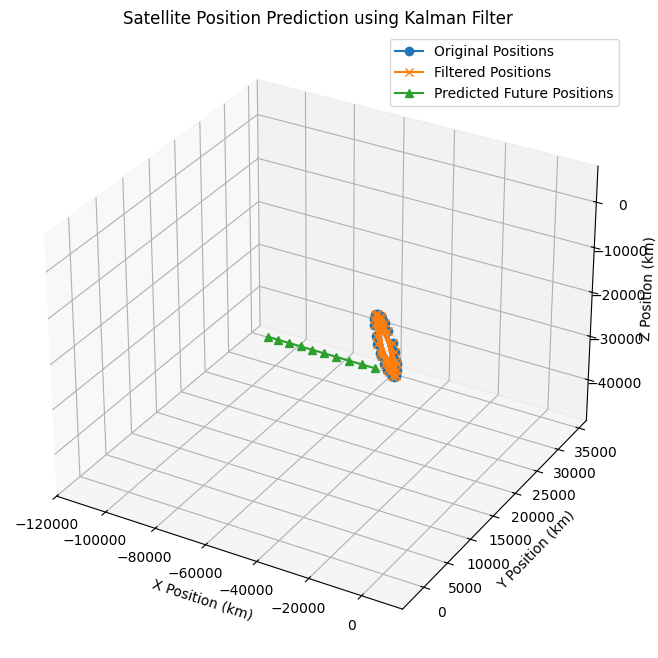

Future position at step 2: [-22871.03417236   7747.65497089 -15205.54149333]
Future velocity at step 2: [-3.07501736  0.91839392 -1.15150967]


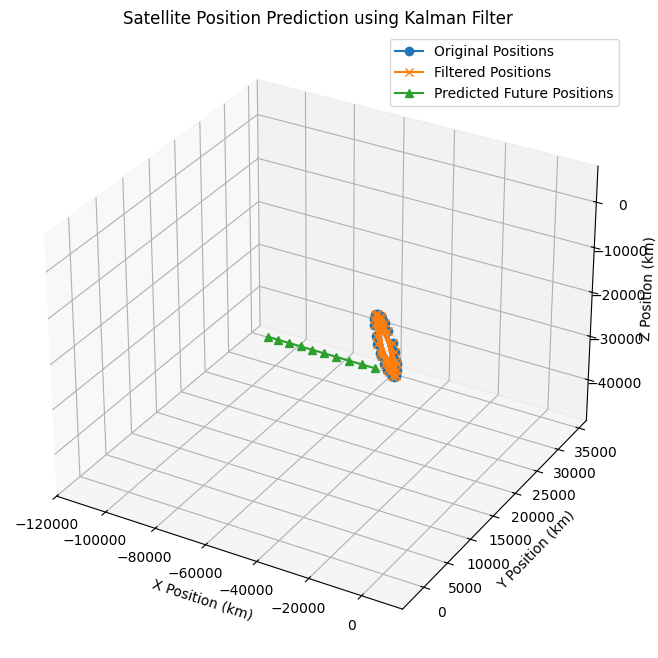

Future position at step 3: [-33941.09667064  11053.87310018 -19350.97631037]
Future velocity at step 3: [-3.07501736  0.91839392 -1.15150967]


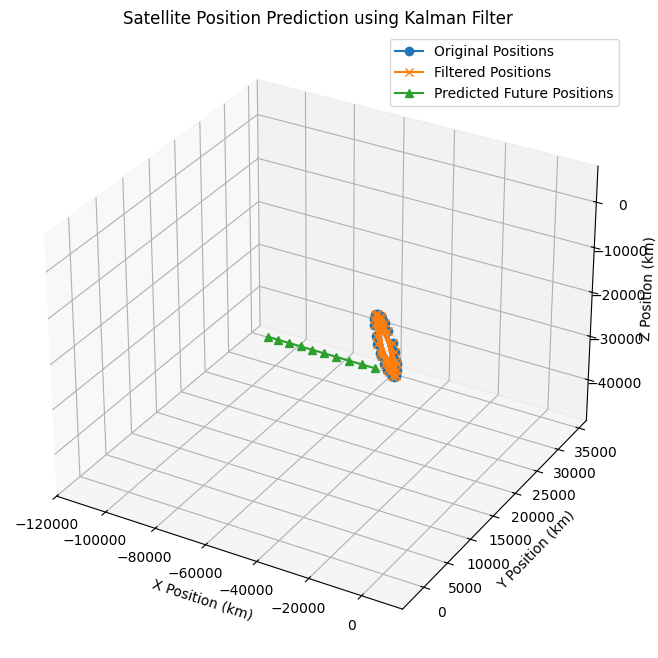

Future position at step 4: [-45011.15916892  14360.09122948 -23496.41112741]
Future velocity at step 4: [-3.07501736  0.91839392 -1.15150967]


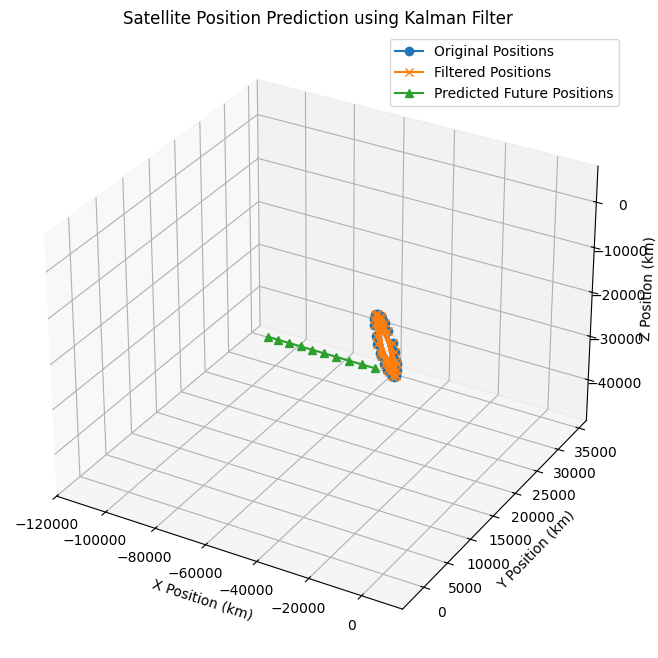

Future position at step 5: [-56081.2216672   17666.30935877 -27641.84594444]
Future velocity at step 5: [-3.07501736  0.91839392 -1.15150967]


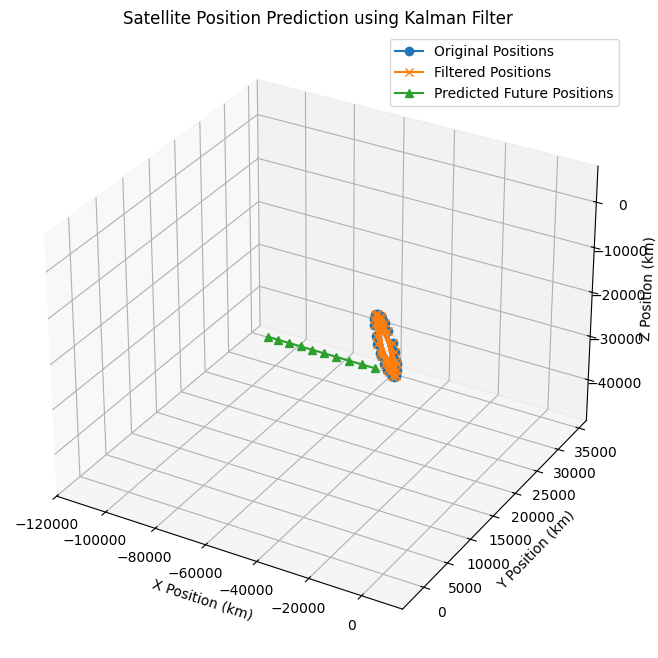

Future position at step 6: [-67151.28416548  20972.52748806 -31787.28076148]
Future velocity at step 6: [-3.07501736  0.91839392 -1.15150967]


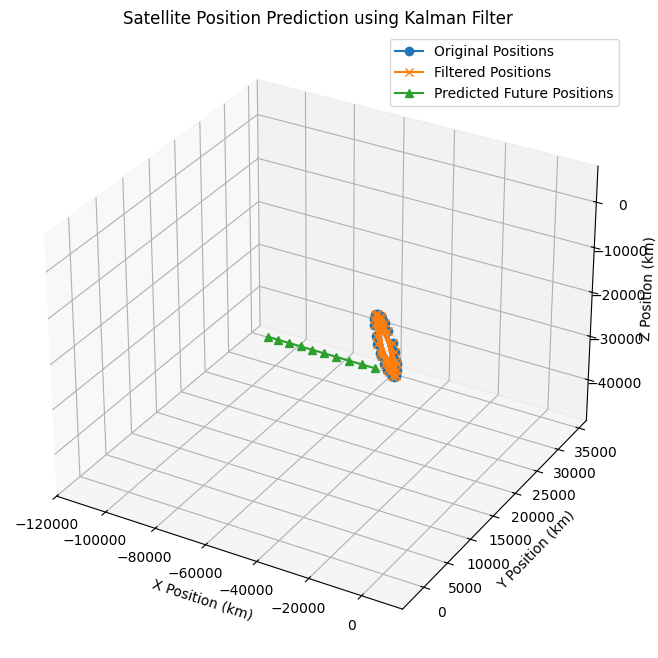

Future position at step 7: [-78221.34666376  24278.74561736 -35932.71557852]
Future velocity at step 7: [-3.07501736  0.91839392 -1.15150967]


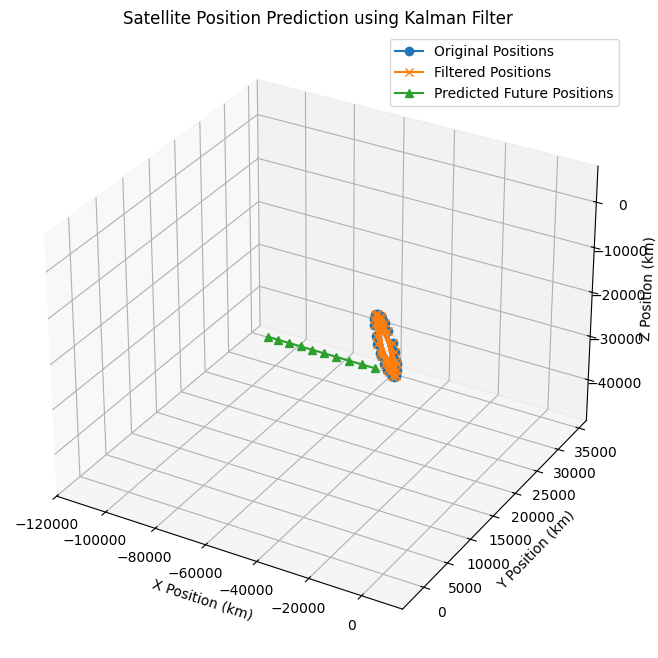

Future position at step 8: [-89291.40916203  27584.96374665 -40078.15039555]
Future velocity at step 8: [-3.07501736  0.91839392 -1.15150967]


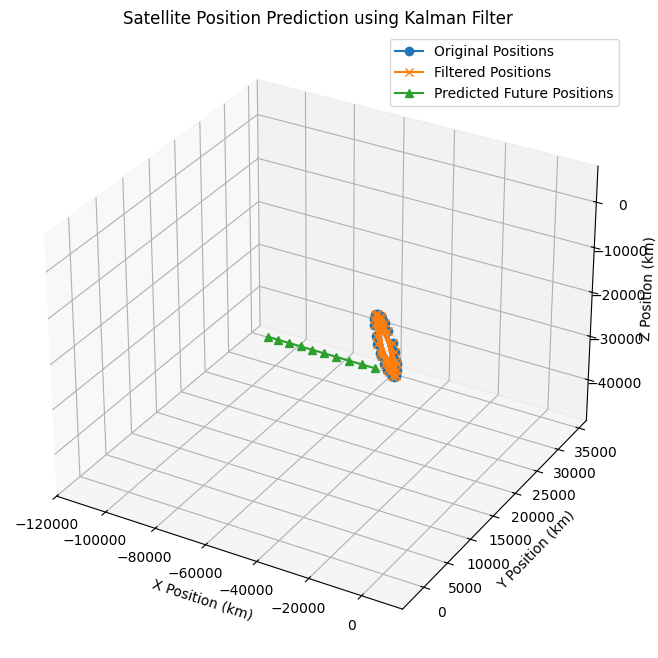

Future position at step 9: [-100361.47166031   30891.18187595  -44223.58521259]
Future velocity at step 9: [-3.07501736  0.91839392 -1.15150967]


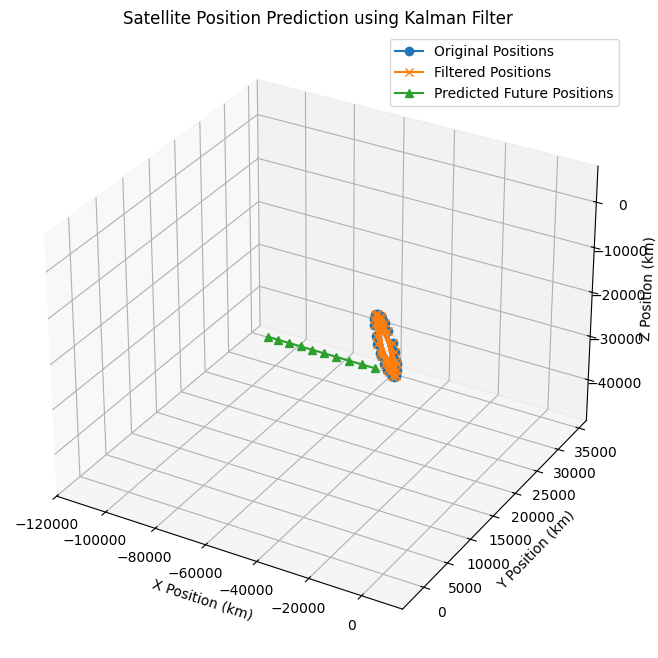

Future position at step 10: [-111431.53415859   34197.40000524  -48369.02002963]
Future velocity at step 10: [-3.07501736  0.91839392 -1.15150967]


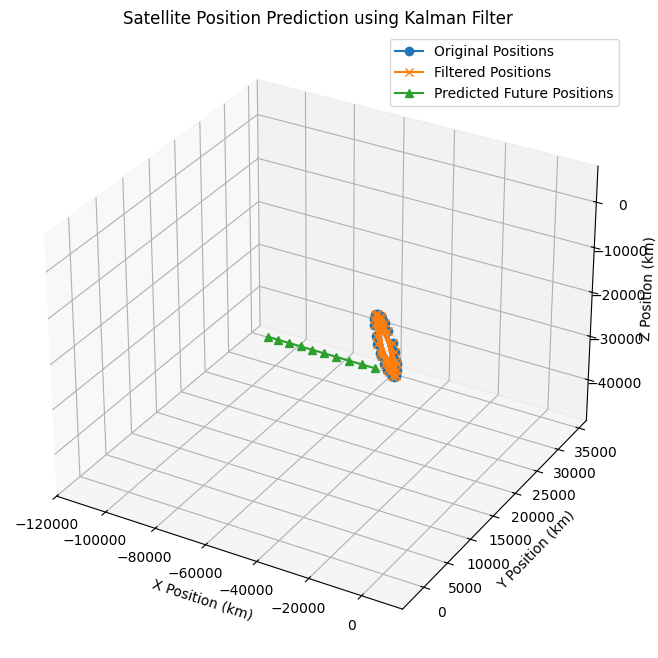

In [ ]:
# use these snapshots to predict the future position of the debris using a Kalman filter.
# Extract positions and velocities from snapshots
positions = np.array([[snapshot['x'], snapshot['y'], snapshot['z']] for snapshot in snapshots])
velocities = np.array([[snapshot['vx'], snapshot['vy'], snapshot['vz']] for snapshot in snapshots])
times = np.array([snapshot['time'] for snapshot in snapshots])

# Define the initial state (position and velocity)
initial_state = np.hstack((positions[0], velocities[0]))

# Define the transition matrix for the Kalman Filter
dt = 3600  # time step in seconds (1 hour)
transition_matrix = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

# Define the observation matrix
observation_matrix = np.eye(6)

# Define the process noise covariance matrix
process_noise_cov = np.eye(6) * 0.1

# Define the observation noise covariance matrix
observation_noise_cov = np.eye(6) * 0.1

# Initialize the Kalman Filter
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state,
    initial_state_covariance=np.eye(6),
    transition_covariance=process_noise_cov,
    observation_covariance=observation_noise_cov
)

# Apply the Kalman Filter to the snapshots
filtered_state_means, filtered_state_covariances = kf.filter(np.hstack((positions, velocities)))

# Predict the future position and velocity
future_steps = 10  # number of future steps to predict
predicted_positions = []
predicted_velocities = []

current_state = filtered_state_means[-1]
for _ in range(future_steps):
    current_state = np.dot(transition_matrix, current_state)
    predicted_positions.append(current_state[:3])
    predicted_velocities.append(current_state[3:])

# Print the predicted future positions and velocities
for i in range(future_steps):
    print(f"Future position at step {i+1}: {predicted_positions[i]}")
    print(f"Future velocity at step {i+1}: {predicted_velocities[i]}")
    # Plot the results
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original positions
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Original Positions', marker='o')

    # Plot the filtered positions
    ax.plot(filtered_state_means[:, 0], filtered_state_means[:, 1], filtered_state_means[:, 2], label='Filtered Positions', marker='x')

    # Plot the predicted future positions
    predicted_positions = np.array(predicted_positions)
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], label='Predicted Future Positions', marker='^')

    # Set labels and title
    ax.set_xlabel('X Position (km)')
    ax.set_ylabel('Y Position (km)')
    ax.set_zlabel('Z Position (km)')
    ax.set_title('Satellite Position Prediction using Kalman Filter')
    ax.legend()

    # Show the plot
    plt.show()

Epoch 1/50


/Users/pulkit/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - loss: 15692852.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 15478841.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 15364941.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 15191750.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 15057590.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14908087.0000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14843345.0000
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14746377.0000
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 14649652.0000
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14552083.0000
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14454473.0000
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14343942.0000
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14240097.0000
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 14142675.0000
Epoch 15/50

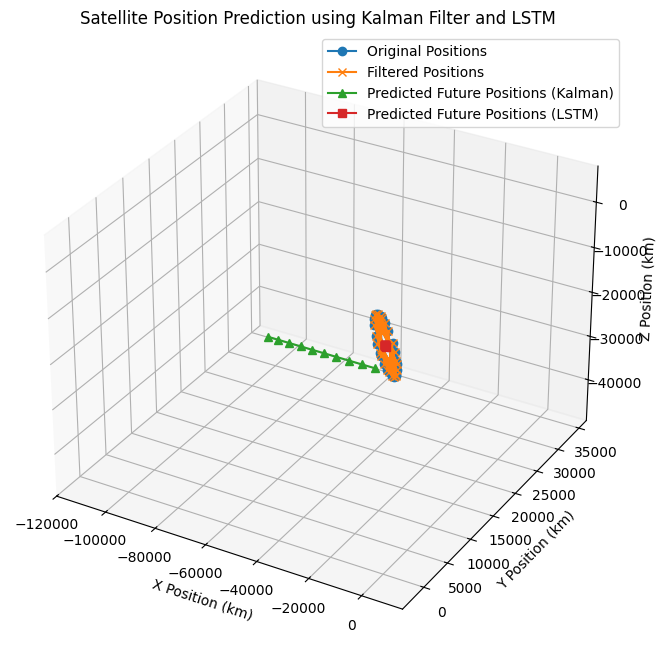

Future position at step 2: [-236.83578  206.86287 -629.53925]


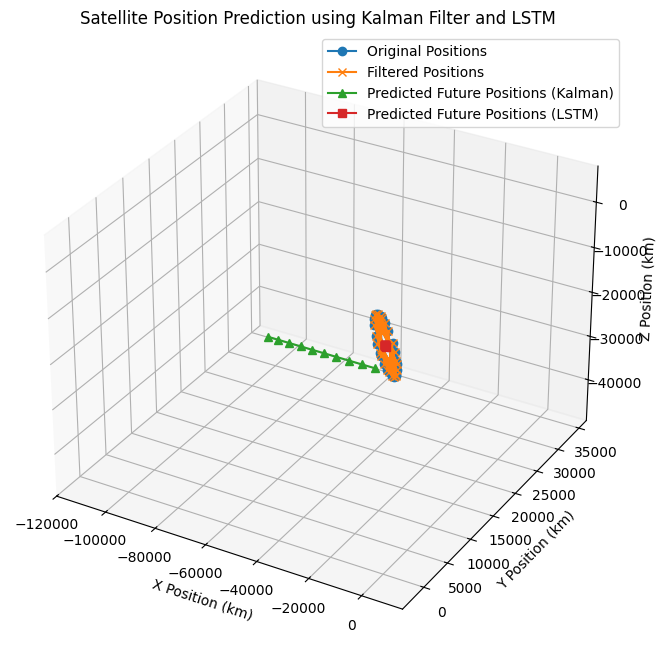

Future position at step 3: [-420.1371     56.045334 -311.68835 ]


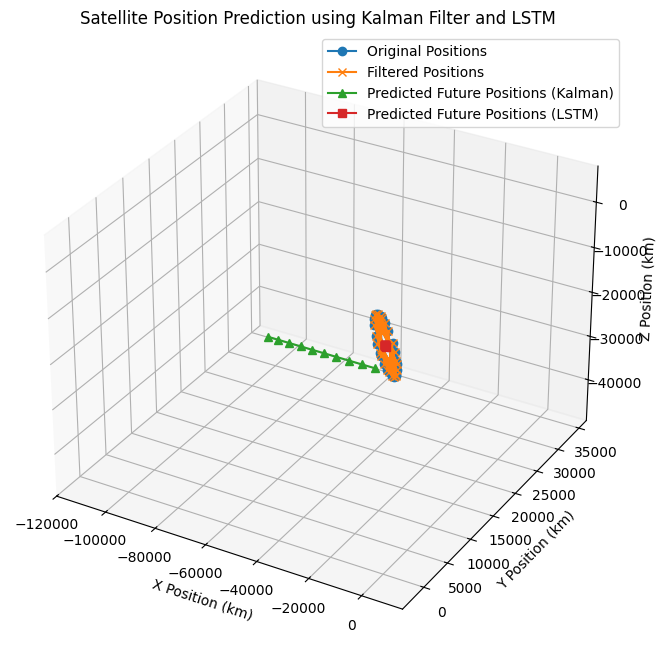

Future position at step 4: [ 14.684976 -58.049747  -6.173151]


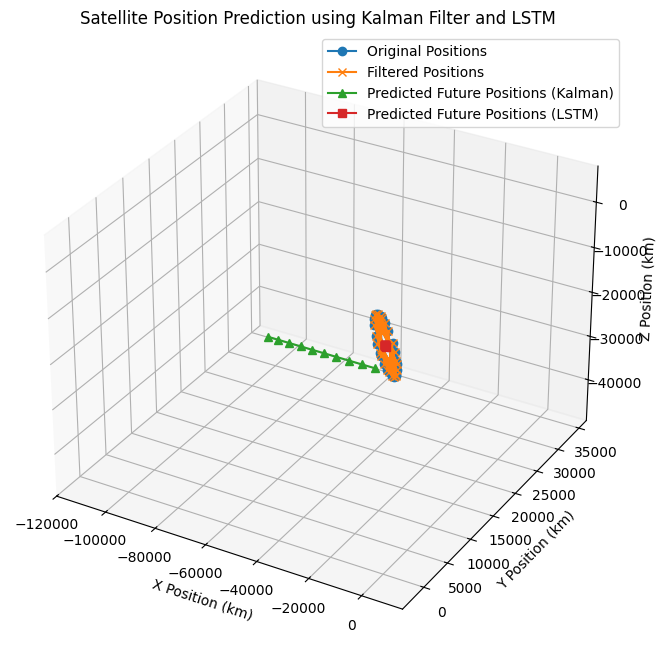

Future position at step 5: [-17.558523 -19.311186  24.197771]


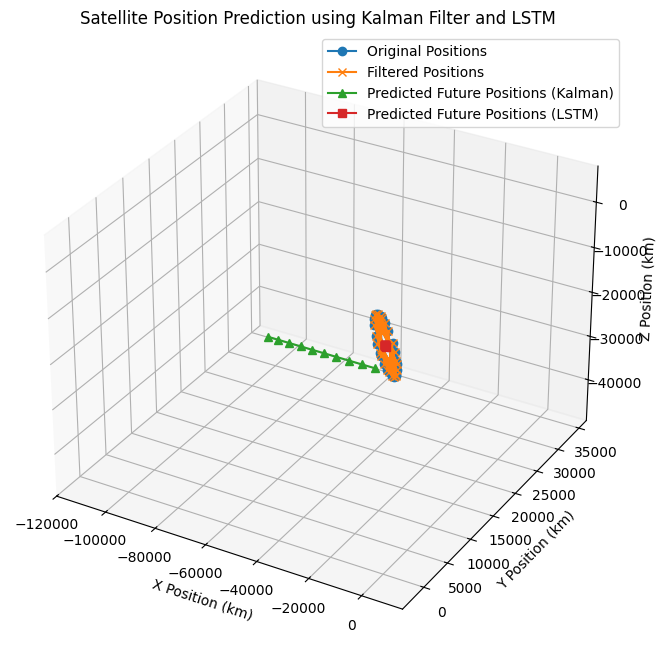

Future position at step 6: [ 1.5468631 -7.9851055 -5.355763 ]


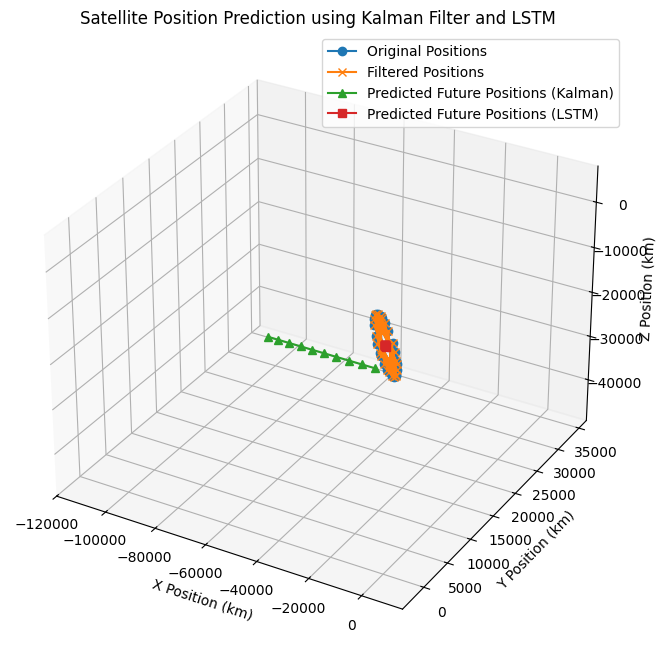

Future position at step 7: [-0.08595325 -4.7218595  -1.7118863 ]


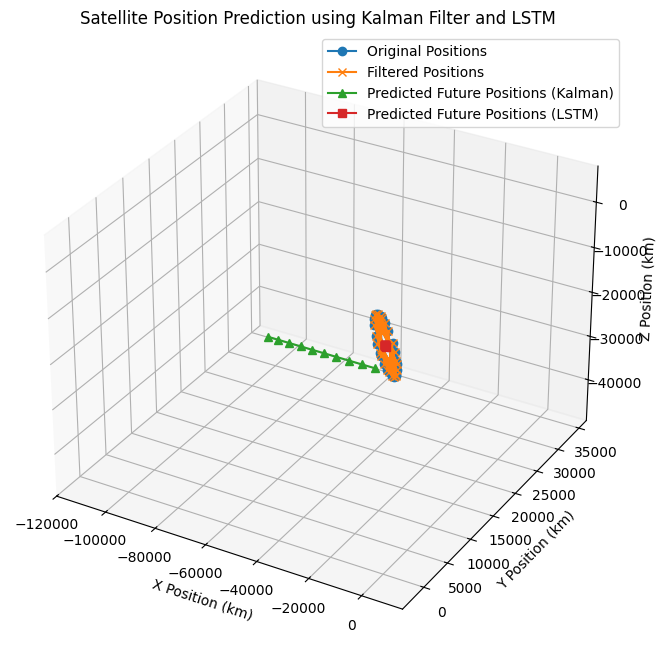

Future position at step 8: [-1.3703357  -0.46100268  0.07389909]


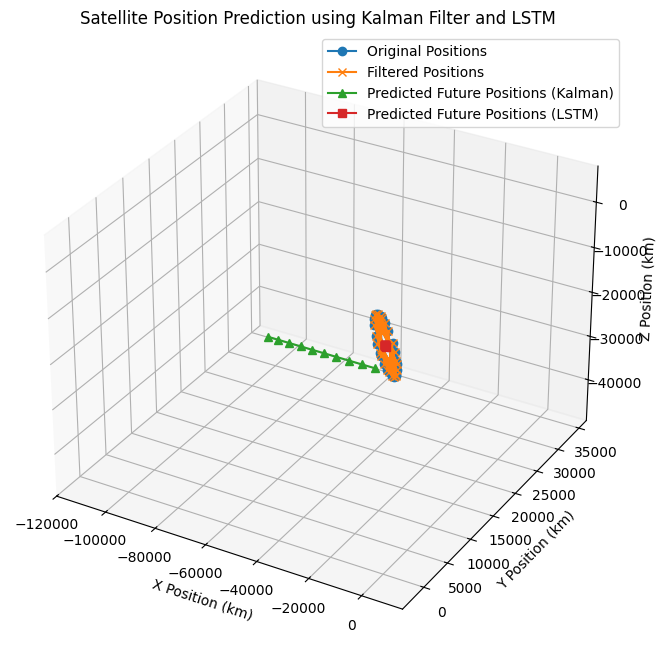

Future position at step 9: [-0.47071385 -0.15444192 -0.43745416]


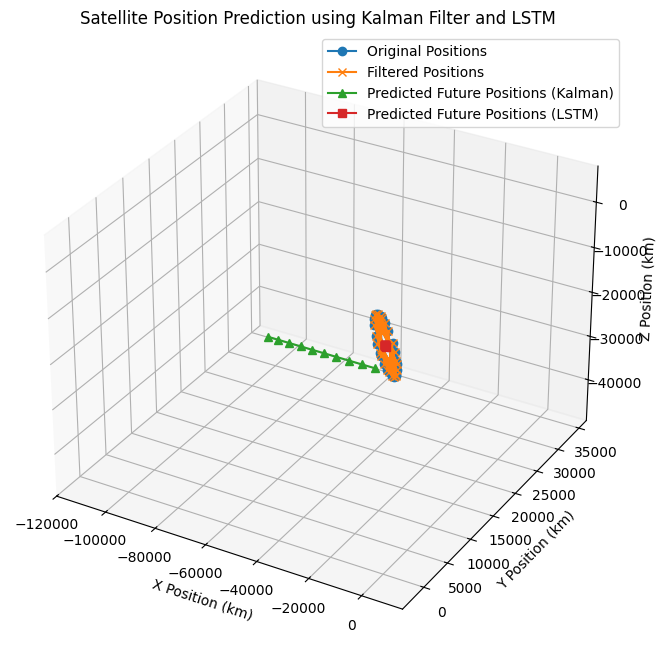

Future position at step 10: [-0.16995466 -0.19520596 -0.209901  ]


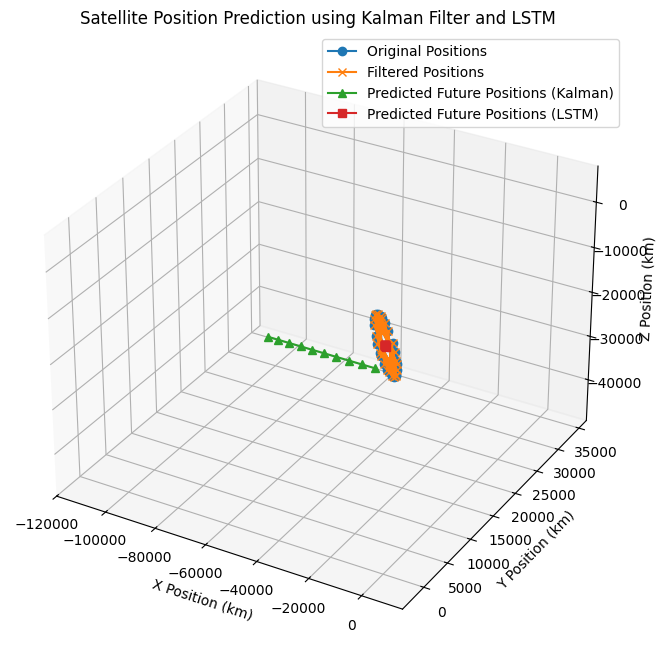

In [ ]:
# use the LSTM model to predict the future position of the satellite.
# Prepare the data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :3])  # Predicting only the position
    return np.array(X), np.array(y)

# Define time steps
time_steps = 3

# Create the dataset for LSTM
X_lstm, y_lstm = create_lstm_dataset(filtered_state_means, time_steps)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, filtered_state_means.shape[1])))
model.add(Dense(3))  # Output layer for predicting x, y, z positions
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the LSTM model
model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, verbose=1)

# Predict future positions using the trained LSTM model
future_positions_lstm = []
current_input = filtered_state_means[-time_steps:]

for _ in range(future_steps):
    current_input_reshaped = current_input.reshape((1, time_steps, filtered_state_means.shape[1]))
    predicted_position = model.predict(current_input_reshaped)
    future_positions_lstm.append(predicted_position[0])
    current_input = np.vstack((current_input[1:], np.hstack((predicted_position, current_input[-1, 3:].reshape(1, -1)))))

# Print the predicted future positions
for i, pos in enumerate(future_positions_lstm):
    print(f"Future position at step {i+1}: {pos}")
    # Convert future positions to numpy array for easier plotting
    future_positions_lstm = np.array(future_positions_lstm)

    # Plot the results
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original positions
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Original Positions', marker='o')

    # Plot the filtered positions
    ax.plot(filtered_state_means[:, 0], filtered_state_means[:, 1], filtered_state_means[:, 2], label='Filtered Positions', marker='x')

    # Plot the predicted future positions using Kalman Filter
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], label='Predicted Future Positions (Kalman)', marker='^')

    # Plot the predicted future positions using LSTM
    ax.plot(future_positions_lstm[:, 0], future_positions_lstm[:, 1], future_positions_lstm[:, 2], label='Predicted Future Positions (LSTM)', marker='s')

    # Set labels and title
    ax.set_xlabel('X Position (km)')
    ax.set_ylabel('Y Position (km)')
    ax.set_zlabel('Z Position (km)')
    ax.set_title('Debris Position Prediction using Kalman Filter and LSTM')
    ax.legend()

    # Show the plot
    plt.show()

Combined future position at step 1: [-5614.05233485  2027.06787758 -5385.64571486]
Combined future position at step 2: [-11553.93497864   3977.25892008  -7917.54036947]
Combined future position at step 3: [-17180.6168778    5554.95921702  -9831.33233243]
Combined future position at step 4: [-22498.23709665   7151.020741   -11751.29213921]
Combined future position at step 5: [-28049.39009519   8823.49908647 -13808.82408669]
Combined future position at step 6: [-33574.8686512   10482.27119127 -15896.31826222]
Combined future position at step 7: [-39110.7163085   12137.01187895 -17967.2137324 ]
Combined future position at step 8: [-44646.38974887  13792.25137199 -20039.03824823]
Combined future position at step 9: [-50180.97118708  15445.51371701 -22112.01133338]
Combined future position at step 10: [-55715.85205662  17098.60239964 -24184.61496532]


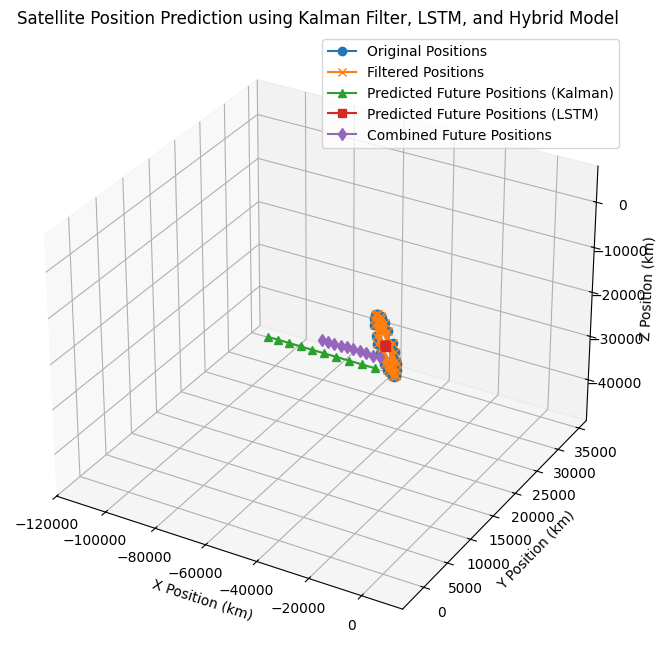

In [ ]:
# build a hybrid model that combines the Kalman Filter and LSTM to predict the future position of the debris.
# Combine Kalman Filter and LSTM predictions
def hybrid_model(kf_predictions, lstm_predictions, alpha=0.5):
    """
    Combine predictions from Kalman Filter and LSTM using a weighted average.

    Args:
        kf_predictions (np.ndarray): Predictions from the Kalman Filter.
        lstm_predictions (np.ndarray): Predictions from the LSTM model.
        alpha (float): Weight for the Kalman Filter predictions. (1 - alpha) is the weight for LSTM predictions.

    Returns:
        np.ndarray: Combined predictions.
    """
    return alpha * kf_predictions + (1 - alpha) * lstm_predictions

# Get the combined predictions
combined_predictions = hybrid_model(predicted_positions, future_positions_lstm)

# Print the combined predictions
for i, pos in enumerate(combined_predictions):
    print(f"Combined future position at step {i+1}: {pos}")

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original positions
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], label='Original Positions', marker='o')

# Plot the filtered positions
ax.plot(filtered_state_means[:, 0], filtered_state_means[:, 1], filtered_state_means[:, 2], label='Filtered Positions', marker='x')

# Plot the predicted future positions using Kalman Filter
ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], label='Predicted Future Positions (Kalman)', marker='^')

# Plot the predicted future positions using LSTM
ax.plot(future_positions_lstm[:, 0], future_positions_lstm[:, 1], future_positions_lstm[:, 2], label='Predicted Future Positions (LSTM)', marker='s')

# Plot the combined future positions
ax.plot(combined_predictions[:, 0], combined_predictions[:, 1], combined_predictions[:, 2], label='Combined Future Positions', marker='d')

# Set labels and title
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
ax.set_title('Satellite Position Prediction using Kalman Filter, LSTM, and Hybrid Model')
ax.legend()

# Show the plot
plt.show()